In [1]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation, Reshape, Input
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, load_model
from keras.utils  import to_categorical
from datetime     import datetime
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

Using TensorFlow backend.


In [2]:
data_dir = 'numpy_arrays'
X  = 'train_digit_features.npy'
y  = 'train_digit_labels.npy'

train_features = np.load(os.path.join(data_dir, X))
train_labels   = np.load(os.path.join(data_dir, y))

X  = 'test_digit_features.npy'
y  = 'test_digit_labels.npy'

test_features = np.load(os.path.join(data_dir, X))
test_labels   = np.load(os.path.join(data_dir, y))

#print("Features:",train_features.shape)
#print("Labels", train_labels.shape)

LABEL: 3.0


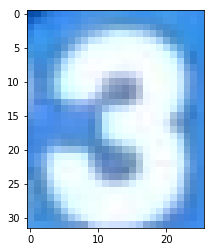

In [3]:
%matplotlib inline

def display(feature_array, label_array, num):
    print("LABEL: {}".format(label_array[num] ))
    fig,ax  = plt.subplots(1)
    ax.imshow(feature_array[num])

display(train_features, train_labels, 3)

In [4]:
# Preprocessing features
from skimage.transform import resize
%matplotlib inline

def remove_zero_dims(features, labels):
    skimmed_features = []
    skimmed_labels   = []
    
    for i, feature in enumerate(features):
        height, width = feature.shape[0], feature.shape[1]
        to_height = 25
        try:
            to_width = to_height * ( (1.0 * width) / height)
            tmp = resize(feature, (int(to_height), int(to_width), 3), mode='constant')
            skimmed_features.append(feature)
            skimmed_labels.append(labels[i])
        except Exception as e:
            print("ERROR: {}. DIMS: {} {} {}".format(e, i, height, width))

    return np.array(skimmed_features), np.array(skimmed_labels)

        
#tmp_features, tmp_labels = remove_zero_dims(train_features, train_labels)
#print(tmp_features.shape)
#print(tmp_labels.shape)

In [5]:
def crop(features, to_height):
    #mean_width = np.mean([f.shape[1] for f in features])
    #print("MEAN WIDTH: {}".format(mean_width))
    
    tmp_resized_features = []
    for i, feature in enumerate(features):
        #print(feature.shape)
        height, width = feature.shape[0], feature.shape[1]

        to_width = to_height * ( (1.0 * width) / height)
        #tmp = resize(feature, (int(to_height), int(to_width), 3), mode='constant')
        tmp = resize(feature, (50, 25, 3), mode='constant')
        #print(tmp.shape)
        tmp_resized_features.append(tmp)
        
    return np.array(tmp_resized_features)

def pad_features(features):
    new_features = []
    for feature in features:
        #print(feature.shape)
        height, width, _ = feature.shape
        if height > width:
            pad = np.zeros((int(height), int((height - width) / 2), 3))
            tmp = np.concatenate((pad, feature, pad), axis=1)
#            if tmp.shape[0] > tmp.shape[1]:
#                one_px_pad = np.zeros((int(height), 1, 3))
#                tmp = np.concatenate((tmp, one_px_pad), axis=1)
                
        else:
#            print(feature.shape)
            pad = np.zeros((int((width - height) / 2), int(width), 3))
            tmp = np.concatenate((pad, feature, pad), axis=0)
#            print(tmp.shape)
        new_features.append(tmp)
    return np.array(new_features)


def resize_32x32(features):
    return np.array([resize(f, (32, 32, 3), mode='constant') for f in features])

def resize_64x64(features):
    return np.array([resize(f, (64, 64, 3), mode='constant') for f in features])


In [20]:
def preprocess_features(features, labels):
    features, labels = remove_zero_dims(features, labels)
    features = pad_features(features)
    features = resize_32x32(features)
    
    return features, labels

In [21]:
def preprocess_labels(labels):
    # Removing labels that are not 0 - 9.
    labels[labels == 10.0] = 0.0

    # One hot encoding
    encoded_labels = to_categorical(labels)
    
    return encoded_labels

In [8]:
processed_train_features, labels = preprocess_features(train_features, train_labels)  
processed_train_labels = preprocess_labels(labels)

processed_test_features, labels = preprocess_features(test_features, test_labels)  
processed_test_labels = preprocess_labels(labels)

ERROR: float division by zero. DIMS: 543 30 0
ERROR: float division by zero. DIMS: 1571 108 0
ERROR: float division by zero. DIMS: 6875 38 0
ERROR: float division by zero. DIMS: 11710 40 0
ERROR: float division by zero. DIMS: 15150 69 0
ERROR: float division by zero. DIMS: 20600 46 0
ERROR: float division by zero. DIMS: 26065 33 0
ERROR: float division by zero. DIMS: 28859 32 0
ERROR: float division by zero. DIMS: 33178 17 0
ERROR: float division by zero. DIMS: 40034 68 0
ERROR: float division by zero. DIMS: 40296 30 0
ERROR: float division by zero. DIMS: 42428 46 0
ERROR: float division by zero. DIMS: 44972 39 0
ERROR: float division by zero. DIMS: 45752 49 0
ERROR: float division by zero. DIMS: 45780 53 0
ERROR: float division by zero. DIMS: 49123 16 0
ERROR: float division by zero. DIMS: 52328 46 0
ERROR: float division by zero. DIMS: 58190 64 0
ERROR: float division by zero. DIMS: 60511 50 0
ERROR: float division by zero. DIMS: 60866 54 0
ERROR: float division by zero. DIMS: 62449 

Train feature shape: (73227, 32, 32, 3)
Train label shape: (73227, 10)
Test feature shape: (26024, 32, 32, 3)
Test label shape: (26024, 10)
LABEL: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

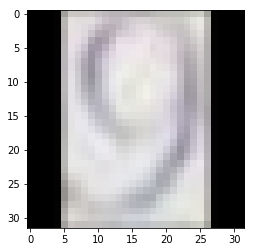

In [10]:
print("Train feature shape:", processed_train_features.shape)
print("Train label shape:", processed_train_labels.shape)
print("Test feature shape:", processed_test_features.shape)
print("Test label shape:", processed_test_labels.shape)

pic = -1
display(processed_train_features, processed_train_labels, pic)
processed_train_labels[pic]

In [11]:
# Models
def dense_various_size_model(in_shape):
    inputs = Input(shape=(3,None,None))
    x = Dense(32, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    x = Flatten()(x)
    x = Dense(10, activation='softmax')(x)
    
    x = Model(inputs=inputs, outputs=x)
    x.summary()
    return x
    
def dense_model(in_shape):
    model = Sequential()
    model.add(Dense(32, input_shape=in_shape))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dense(8))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.summary()
    return model

def pooling_model(in_shape):
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=in_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    return model

def cnn_model(in_shape):
    model = Sequential()
    model.add(Conv2D(filters=48, kernel_size=2, padding='same', activation='relu', input_shape=in_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=160, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    
    #model.add(Conv2D(filters=192, kernel_size=2, padding='same', activation='relu'))
    #model.add(Conv2D(filters=192, kernel_size=2, padding='same', activation='relu'))
    #model.add(Conv2D(filters=192, kernel_size=2, padding='same', activation='relu'))
    #model.add(Conv2D(filters=192, kernel_size=2, padding='same', activation='relu'))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    return model


In [13]:
model = cnn_model(processed_train_features.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        624       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 48)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 48)        192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        12352     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         32896     
__________

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
from keras.callbacks import ModelCheckpoint
from time import time

start      = time()
epochs     = 20
time_now   = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = os.path.join('models', 'singledigits_' + str(epochs) + 'epochs_' + time_now +'.hdf5')

print("MODEL FILE: {}".format(model_path))

checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, save_best_only=True, monitor='acc',)

model.fit(processed_train_features, 
          processed_train_labels,
          epochs=epochs, 
          batch_size=32,
          validation_data=(processed_test_features, processed_test_labels),
          callbacks=[checkpointer], 
          verbose=1)

print("TIME: {}".format(time() - start))

MODEL FILE: models/singledigits_20epochs_20190716_133507.hdf5
Train on 73227 samples, validate on 26024 samples
Epoch 1/20
73227/73227 [==============================] - 282s - loss: 0.7739 - acc: 0.7492 - val_loss: 0.5638 - val_acc: 0.8164
Epoch 2/20
73227/73227 [==============================] - 286s - loss: 0.4109 - acc: 0.8747 - val_loss: 0.4801 - val_acc: 0.8561
Epoch 3/20
73227/73227 [==============================] - 286s - loss: 0.3458 - acc: 0.8966 - val_loss: 0.9107 - val_acc: 0.7167
Epoch 4/20
73227/73227 [==============================] - 285s - loss: 0.3054 - acc: 0.9095 - val_loss: 0.3854 - val_acc: 0.8945
Epoch 5/20
73227/73227 [==============================] - 286s - loss: 0.2769 - acc: 0.9184 - val_loss: 0.4046 - val_acc: 0.8893
Epoch 6/20
73227/73227 [==============================] - 286s - loss: 0.2530 - acc: 0.9251 - val_loss: 0.3956 - val_acc: 0.8917
Epoch 7/20
73227/73227 [==============================] - 286s - loss: 0.2346 - acc: 0.9304 - val_loss: 0.3916 - v

In [16]:
score, acc = model.evaluate(processed_test_features, processed_test_labels, verbose=0)
print("SCORE: {}, ACCURACY: {}".format(score, acc))

SCORE: 0.5371681475173596, ACCURACY: 0.9041269597294804


In [17]:
def predict(array_set):
    y_pred      = model.predict(array_set)
    return np.array([np.argmax(pred) * 1.0 for pred in y_pred])

samples = 10
print(predict(processed_test_features[:samples]))

[ 5.  2.  1.  0.  6.  1.  9.  1.  1.  8.]


LABEL: 5
LABEL: 2
LABEL: 1
LABEL: 0
LABEL: 6
LABEL: 1
LABEL: 9
LABEL: 1
LABEL: 1
LABEL: 8


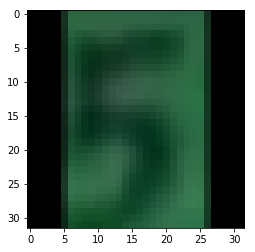

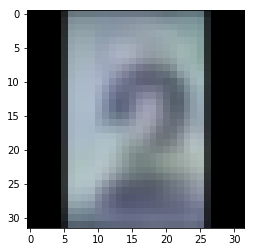

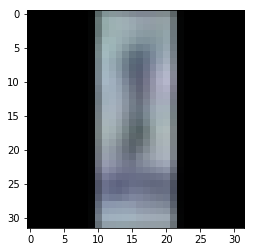

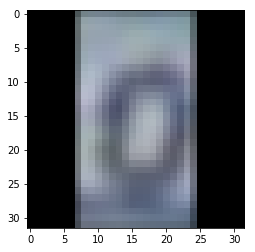

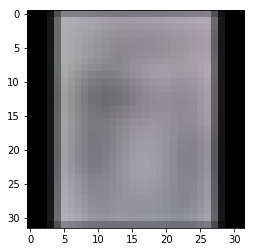

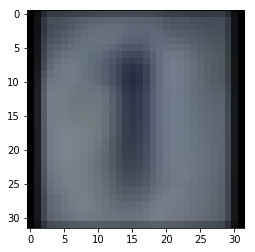

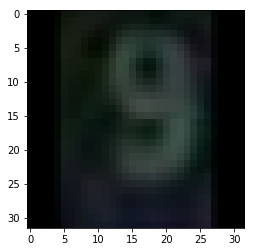

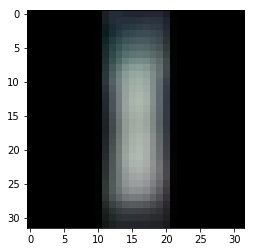

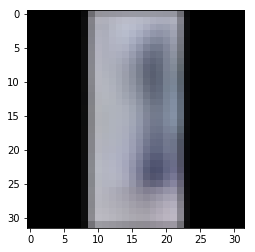

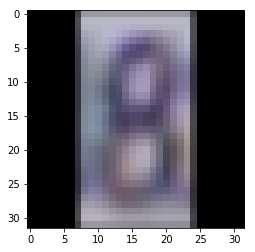

In [19]:
for i in range(samples):
    tmp_labels = [ np.argmax(label) for label in processed_test_labels ]
    display(processed_test_features,  tmp_labels, i)